<a href="https://colab.research.google.com/github/AshishRaj04/Spectral-classification-of-Chandrayaan-2-IIRS/blob/main/Spectral_classification_of_Chandrayaan_2_IIRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing the spectral library for reading the **.qub** and **.hdr** files

In [1]:
! pip install spectral

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 2.5 MB/s eta 0:00:00


Mount the Gdrive

In [2]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Specifying the files path to variables

In [3]:
data_file = "/content/drive/MyDrive/Dataset/Hyperspectral data/data.qub"
header_file = "/content/drive/MyDrive/Dataset/Hyperspectral data/header.hdr"
geometry_file = "/content/drive/MyDrive/Dataset/Hyperspectral data/geometry.csv"

Reading the data

In [4]:
import spectral
import os

In [5]:
data = spectral.io.envi.open(header_file, image=data_file)

In [6]:
hyperspectral_data = data.load()

In [7]:
print(f"Shape of the data: {hyperspectral_data.shape}")

Shape of the data: (9340, 250, 256)


The shape of the data is (9340 , 250 , 256) .
In the 2D space of 9340 x 250 (lines * samples) each pixel or point has 256 different reflectance values at 256 different wavelengths.

Importing the necessary libraries

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten , MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

Plotting the grayscale image of the 9340 x 250 region at 6 different wavelength (bands -  10 , 50 , 100 , 150 , 200 , 256)

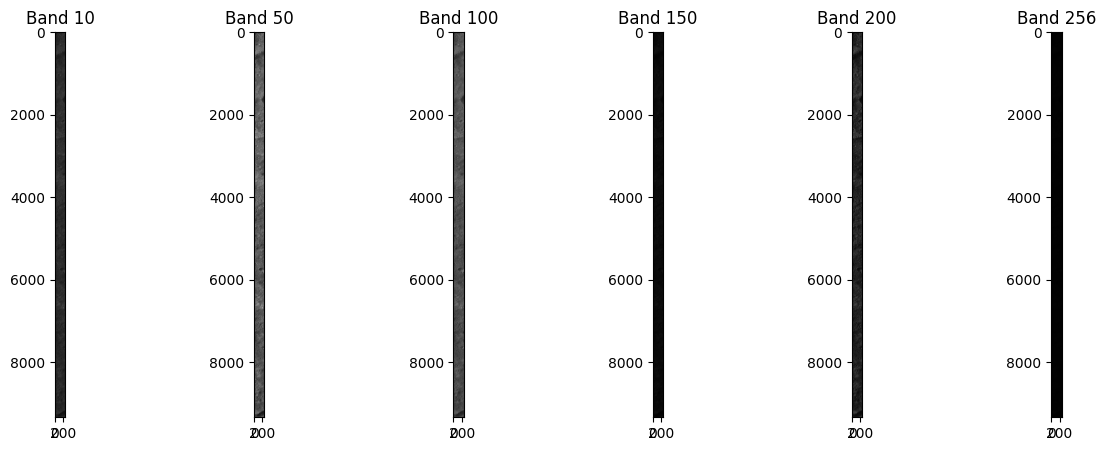

In [9]:
fig, axes = plt.subplots(1, 6, figsize=(15, 5))

axes[0].imshow(hyperspectral_data[:,:,10], cmap='gray')
axes[0].set_title('Band 10')

axes[1].imshow(hyperspectral_data[:,:,50], cmap='gray')
axes[1].set_title('Band 50')

axes[2].imshow(hyperspectral_data[:,:,100], cmap='gray')
axes[2].set_title('Band 100')

axes[3].imshow(hyperspectral_data[:,:,150], cmap='gray')
axes[3].set_title('Band 150')

axes[4].imshow(hyperspectral_data[:,:,200], cmap='gray')
axes[4].set_title('Band 200')

axes[5].imshow(hyperspectral_data[:,:,255], cmap='gray')
axes[5].set_title('Band 256')

plt.show()

# Data Preparation
* Reshaping
* Normalization

Normalizing the data by dividing each reflectance value by the maximum reflectance value . In order to achieve values between 0-1. This will improve the traning time of the ml models.

In [10]:
normalized_data = hyperspectral_data / np.max(hyperspectral_data)

Reducing the dimention of the data to 2-dimentions

In [11]:
flattened_data = normalized_data.reshape(-1, normalized_data.shape[-1])

In [12]:
flattened_data.shape

(2335000, 256)

In [13]:
print(flattened_data[:10])

[[0.00681401 0.00637074 0.00592747 ... 0.00066645 0.00056592 0.00063337]
 [0.00681401 0.00637074 0.00592747 ... 0.00066645 0.00056592 0.00063337]
 [0.00681401 0.00637074 0.00592747 ... 0.00066645 0.00056592 0.00063337]
 ...
 [0.00331437 0.0033712  0.00342802 ... 0.00046547 0.00038309 0.00039068]
 [0.00738867 0.00678232 0.00617597 ... 0.00046661 0.00077682 0.00094651]
 [0.0087032  0.00805969 0.00741618 ... 0.00044319 0.00048961 0.00045587]]


# Dimensionality Reduction using Principal component analysis

* PCA can further reduce the dimensionality by keeping the most important components, making it more manageable for clustering and CNN processing.
* As you can see the 10 principal components capture 98.31% of the variability in your original hyperspectral data

In [14]:
pca = PCA(n_components = 10)
reduces_data = pca.fit_transform(flattened_data)

explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained Variance Ratio by 10 components: {explained_variance}")

Explained Variance Ratio by 10 components: 0.9831166916539452


# Clustering

* Applying **k-mean clustering**

Applying k-mean to seperate the data into 5 different clusters . We will use these clusters as labels for classification.

In [15]:
kmean = KMeans(n_clusters=5)

In [16]:
labels = kmean.fit_predict(reduces_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [17]:
clustered_image = labels.reshape(hyperspectral_data.shape[0] , hyperspectral_data.shape[1])

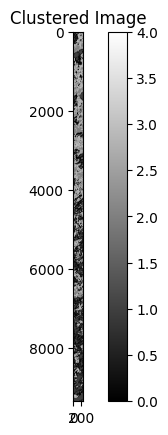

In [18]:
plt.imshow(clustered_image, cmap='gray')
plt.title("Clustered Image")
plt.colorbar()
plt.show()

# Classification
* CNN

Splitting the data into traning and test sets.

In [19]:
X = reduces_data
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train.shape

(1868000, 10)

* Defining the input shape of the data to the CNN Model.
* Then building the structure of the CNN model.

In [21]:
X_train_cnn = X_train.reshape(-1, 10, 1, 1)
X_test_cnn = X_test.reshape(-1, 10, 1, 1)

In [22]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(10 ,1,1) ,  padding='same'),
    MaxPooling2D((2, 1)),
    Conv2D(64, (3, 3), activation='relu',  padding='same'),
    MaxPooling2D((2, 1)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

Then compiling and fitting the model

In [23]:
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
46700/46700 [==============================] - 218s 5ms/step - loss: 0.0987 - accuracy: 0.9571 - val_loss: 0.0422 - val_accuracy: 0.9823
Epoch 2/10
46700/46700 [==============================] - 234s 5ms/step - loss: 0.0475 - accuracy: 0.9799 - val_loss: 0.0422 - val_accuracy: 0.9814
Epoch 3/10
46700/46700 [==============================] - 215s 5ms/step - loss: 0.0411 - accuracy: 0.9825 - val_loss: 0.0343 - val_accuracy: 0.9855
Epoch 4/10
46700/46700 [==============================] - 237s 5ms/step - loss: 0.0364 - accuracy: 0.9846 - val_loss: 0.0378 - val_accuracy: 0.9833
Epoch 5/10
46700/46700 [==============================] - 224s 5ms/step - loss: 0.0334 - accuracy: 0.9858 - val_loss: 0.0256 - val_accuracy: 0.9890
Epoch 6/10
46700/46700 [==============================] - 215s 5ms/step - loss: 0.0305 - accuracy: 0.9869 - val_loss: 0.0475 - val_accuracy: 0.9800
Epoch 7/10
46700/46700 [==============================] - 214s 5ms/step - loss: 0.0288 - accuracy: 0.9877 - val_

In [24]:
cnn_eval = cnn_model.evaluate(X_test_cnn, y_test)
print(f'CNN Accuracy: {cnn_eval[1]}')

14594/14594 [==============================] - 31s 2ms/step - loss: 0.0185 - accuracy: 0.9926
CNN Accuracy: 0.9925974011421204


ON TEST SET OUR MODEL IS GIVING ACCURACY OF MORE THAN 99%